In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.signal import savgol_filter
import pandas as pd
import glob
import cv2

In [55]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [56]:
def compute_MTF(ROI_SFR):
    ROI_LSF = np.abs(np.diff(ROI_SFR))

    ROI_MTF = np.abs(np.fft.fft(ROI_LSF))
    ROI_MTF = ROI_MTF[:]/np.max(ROI_MTF)
    ROI_MTF = ROI_MTF[:len(ROI_MTF)//2]

    return ROI_MTF

In [57]:
file_ROI = glob.glob('rect/*')

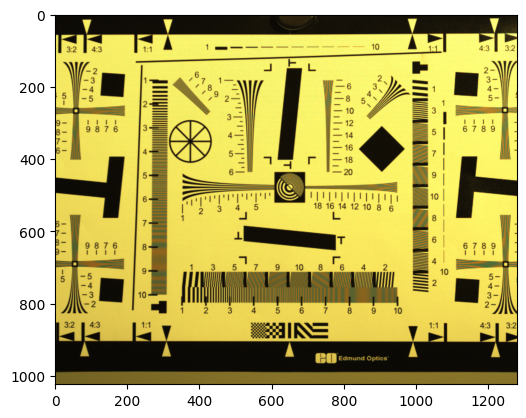

In [58]:
image = plt.imread(file_ROI[0])
plt.imshow(image)
plt.show()

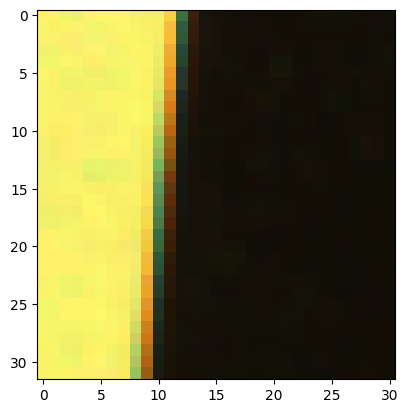

In [59]:
ROI_coords = cv2.selectROI(image)
ROI = image[int(ROI_coords[1]):int(ROI_coords[1] + ROI_coords[3]), int(ROI_coords[0]):int(ROI_coords[0] + ROI_coords[2])]
plt.imshow(ROI)
plt.show()

In [60]:
ROI_R = ROI[:,:,0]
ROI_G = ROI[:,:,1]
ROI_B = ROI[:,:,2]

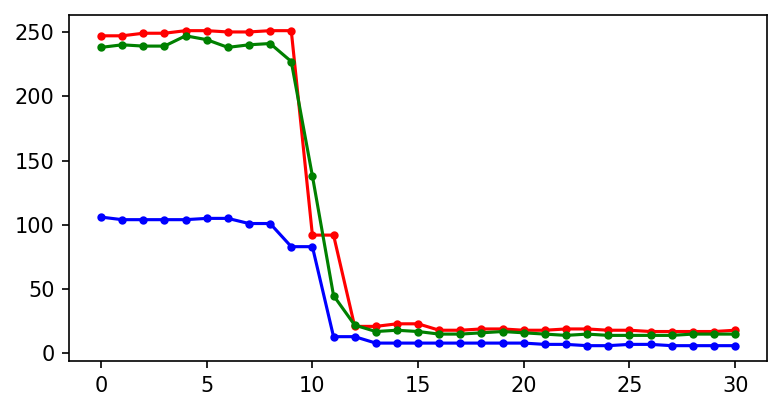

In [61]:
ROI_SFR_R = ROI_R[len(ROI_R)//2]
ROI_SFR_G = ROI_G[len(ROI_G)//2]
ROI_SFR_B = ROI_B[len(ROI_B)//2]

x_SFR = np.arange(0, len(ROI_SFR_R))
plt.figure(figsize = (6,3), dpi = 150, facecolor=None)
plt.plot(x_SFR, ROI_SFR_R, 'r.-', label = 'Red channel SFR')
plt.plot(x_SFR, ROI_SFR_G, 'g.-', label = 'Green channel SFR')
plt.plot(x_SFR, ROI_SFR_B, 'b.-', label = 'Blue channel SFR')

plt.show()

In [62]:
MTF_R = compute_MTF(ROI_R)
MTF_G = compute_MTF(ROI_G)
MTF_B = compute_MTF(ROI_B)

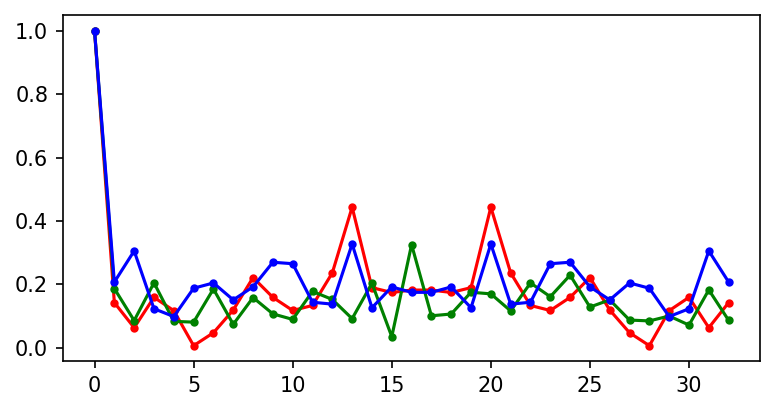

In [48]:
x_MTF = np.arange(0,len(MTF_R))

plt.figure(figsize = (6,3), dpi = 150, facecolor=None)
plt.plot(x_MTF, MTF_R, 'r.-', label = 'Red channel MTF')
plt.plot(x_MTF, MTF_G, 'g.-', label = 'Green channel MTF')
plt.plot(x_MTF, MTF_B, 'b.-', label = 'Blue channel MTF')

plt.show()


In [68]:
#ROI_coords = cv2.selectROI(image)
#ROI = image[int(ROI_coords[1]):int(ROI_coords[1] + ROI_coords[3]), int(ROI_coords[0]):int(ROI_coords[0] + ROI_coords[2])]

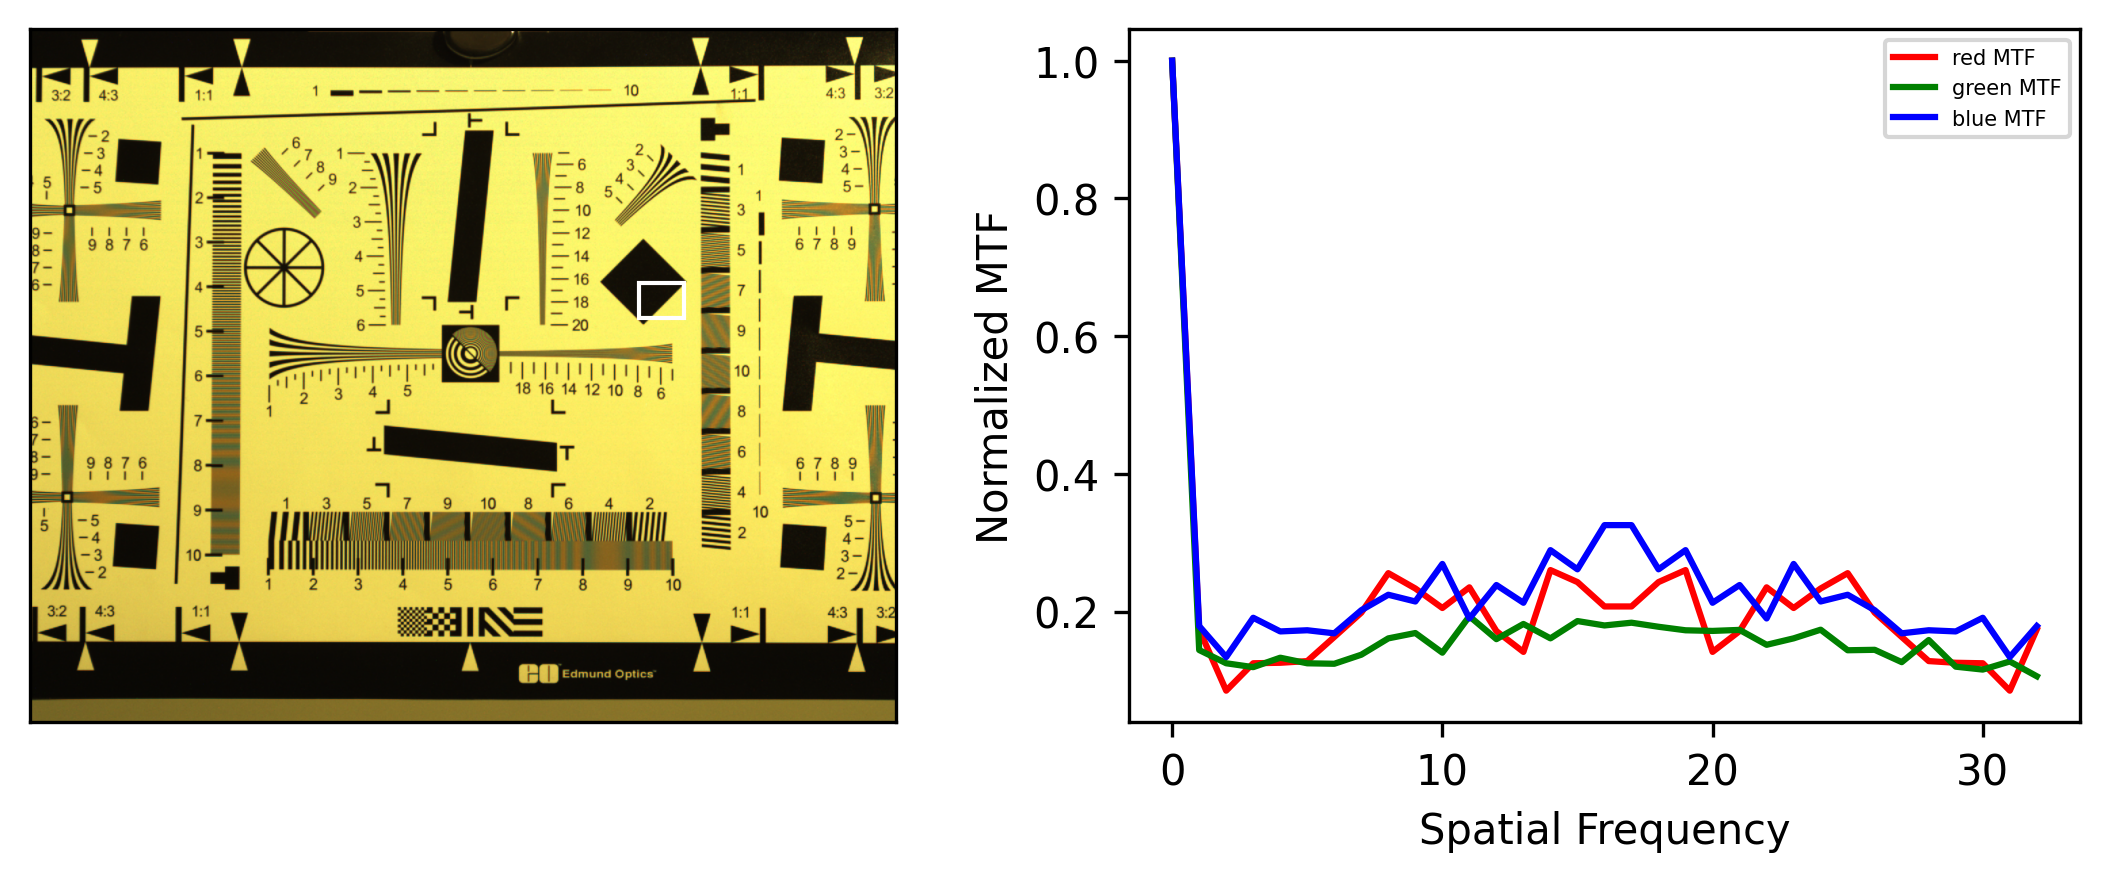

In [69]:
image = plt.imread(file_ROI[0])

ROI_coords = cv2.selectROI(image)
ROI = image[int(ROI_coords[1]):int(ROI_coords[1] + ROI_coords[3]), int(ROI_coords[0]):int(ROI_coords[0] + ROI_coords[2])]

ROI_R = ROI[:,:,0]
ROI_G = ROI[:,:,1]
ROI_B = ROI[:,:,2]

MTF_values_R = []
MTF_values_G = []
MTF_values_B = []
for j in range(len(ROI_R)):
    ESF_R = ROI_R[j]
    ESF_G = ROI_G[j]
    ESF_B = ROI_B[j]

    MTF_R = compute_MTF(ESF_R)
    MTF_G = compute_MTF(ESF_G)
    MTF_B = compute_MTF(ESF_B)

    MTF_values_R.append(MTF_R)
    MTF_values_G.append(MTF_G)
    MTF_values_B.append(MTF_B)

MTF_values_R = np.array(MTF_values_R)
MTF_values_R_median = np.percentile(MTF_values_R, 50, axis=0)
MTF_values_G = np.array(MTF_values_G)
MTF_values_G_median = np.percentile(MTF_values_G, 50, axis=0)
MTF_values_B = np.array(MTF_values_B)
MTF_values_B_median = np.percentile(MTF_values_B, 50, axis=0)


plt.figure(figsize = (6*1.5, 3), dpi = 300, facecolor = None)
plt.subplot(121)
plt.imshow(image)
plt.gca().add_patch(patches.Rectangle((ROI_coords[0],ROI_coords[1]),ROI_coords[2],ROI_coords[3],linewidth=1,edgecolor='white',facecolor='none'))
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.plot(np.arange(0, len(MTF_values_R_median)), MTF_values_R_median, color = 'red', linestyle = 'solid', label = 'red MTF')
plt.plot(np.arange(0, len(MTF_values_R_median)), MTF_values_G_median, color = 'green', linestyle = 'solid', label = 'green MTF')
plt.plot(np.arange(0, len(MTF_values_R_median)), MTF_values_B_median, color = 'blue', linestyle = 'solid', label = 'blue MTF')
plt.ylabel('Normalized MTF')
plt.xlabel('Spatial Frequency')
plt.legend(fontsize = 5)
plt.show()